In [3]:
import matplotlib.pyplot as plt
from matplotlib import  cm
import matplotlib as mpl
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.font_manager as fm
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches
from matplotlib.image import imread

In [15]:
# https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby  , str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', )


# https://blog.csdn.net/qq_32832803/article/details/110910540
def add_north(ax1, labelsize=20, loc_x=0.92, loc_y=0.9, width=0.03, height=0.1, pad=0.14):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax1.get_xlim()
    miny, maxy = ax1.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax1.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax1.add_patch(triangle)


In [5]:
import pandas as pd
import numpy as np
data = pd.read_csv('./perprocess/input/O3/20220223_O3_v2.csv')
lons = data['X_Lon']
lats = data['Y_Lat']
values = np.array(data['M8H_O3'])
vmin = values.min()
vmax = values.max()

In [6]:
# import numpy as np
# lons = set(data['lon'])
# lats = set(data['lat'])
# # map lon lat -> value
# dataDict = {
    
# }
# for lon, lat, value in data.values:
#   dataDict[(lon, lat)] = value

# # lons, lats = np.meshgrid(set(lons),set(lats))
# values = []
# for lon in lons:
#   for lat in lats:
#     values.append(dataDict[(lon, lat)])
# values = np.array(values).reshape(len(lons), len(lats))

In [7]:
# gdf = geopandas.read_file('./CN-border-La.gmt')
# ax.add_geometries(gdf.geometry, ccrs.PlateCarree(), edgecolor='k',linewidth=1.5, alpha=0.1, )


/var/folders/lz/4fpzy07s1yz6z4cpnnch7r240000gn/T/ipykernel_4035/2507760531.py:16: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


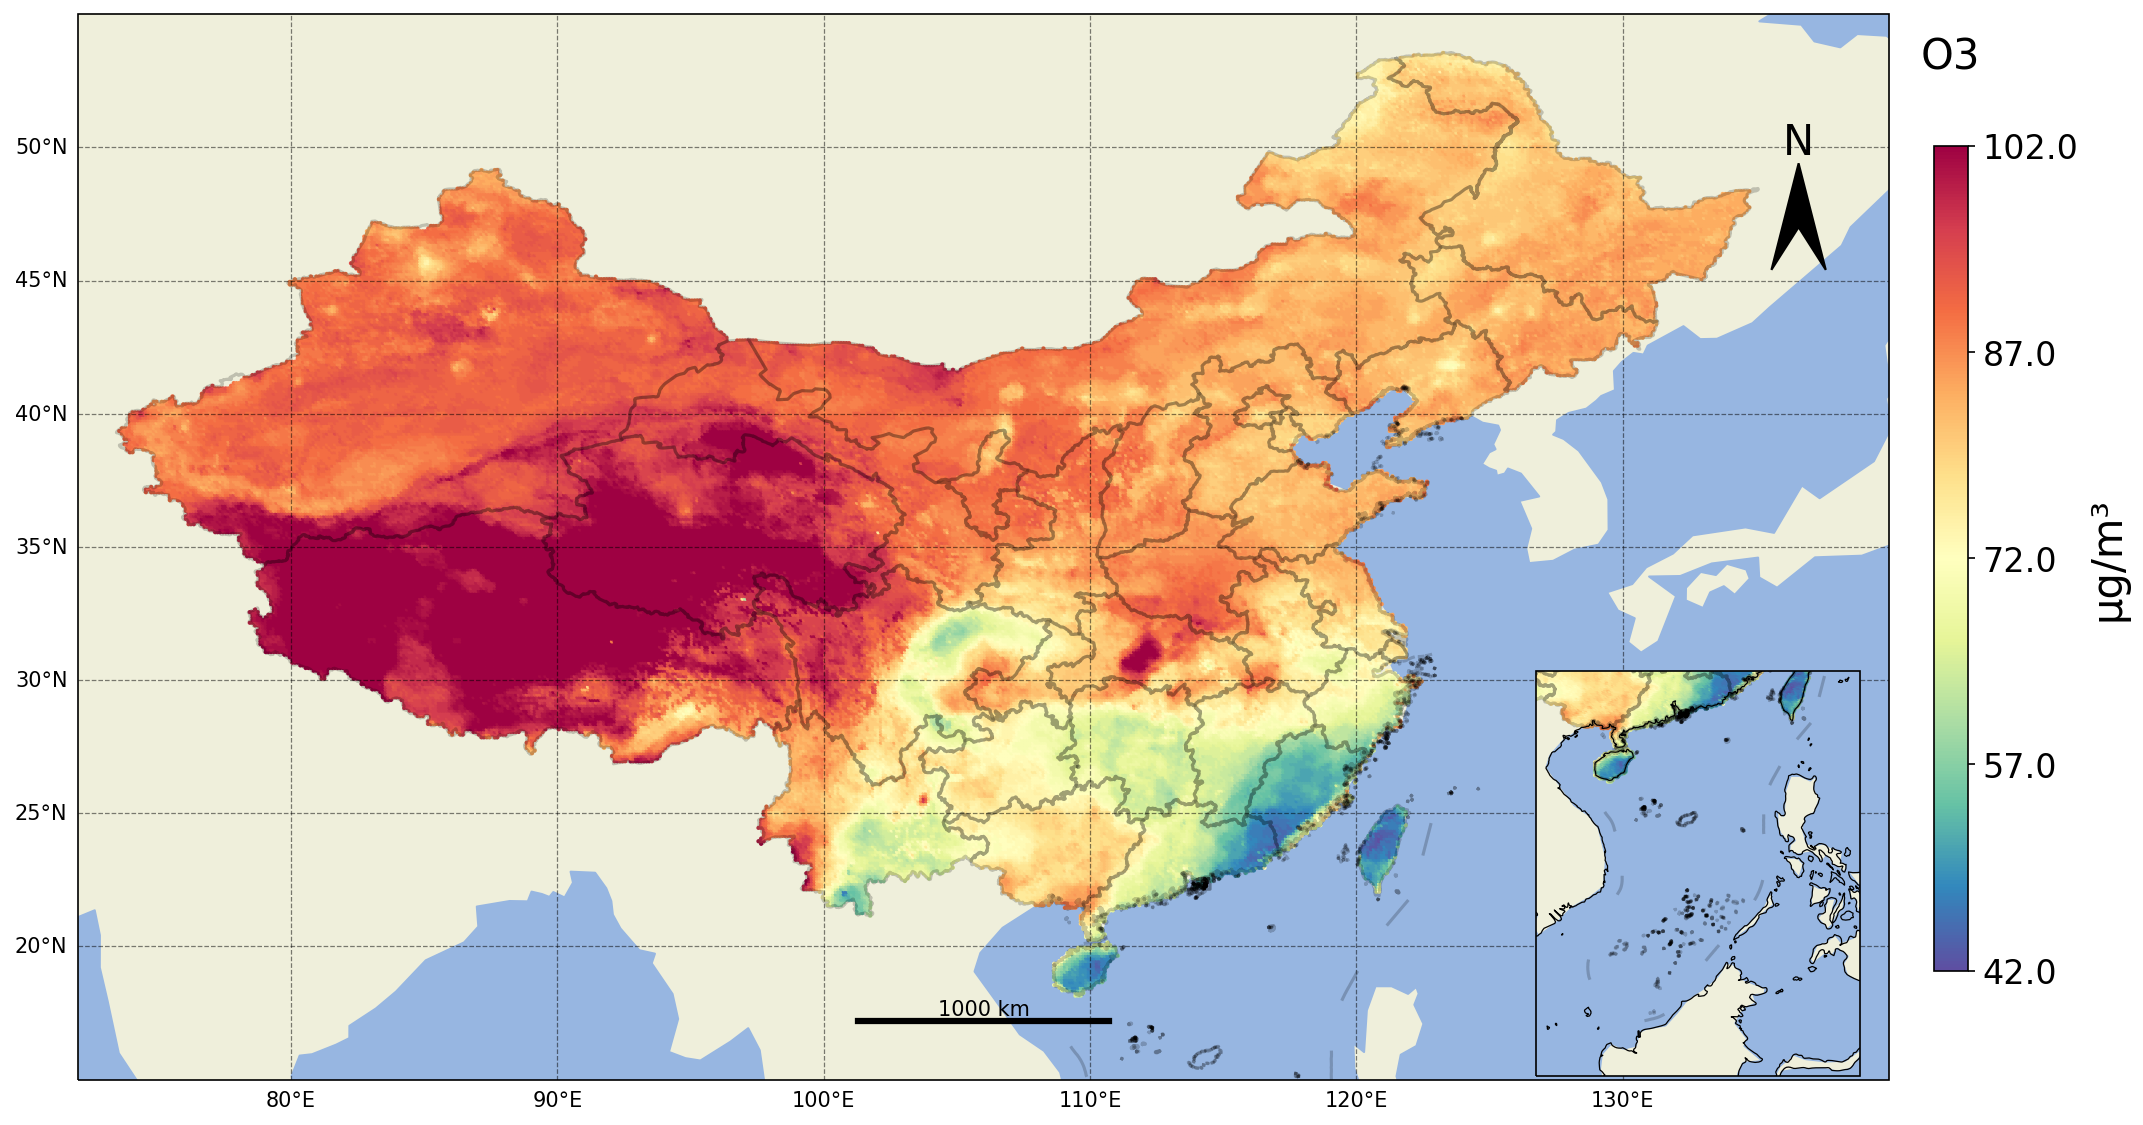

In [18]:
fig = plt.figure(figsize=[15, 10],dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([72, 140, 15, 55], crs=ccrs.PlateCarree())
startLon, endLon, startLat, endLat = ax.get_extent(ccrs.PlateCarree())
# ax.stock_img()
with open('./CN-border-La.gmt') as src:
    context = ''.join([line for line in src if not line.startswith('#')])
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]
# 绘制国界省界
for border in borders:
    ax.plot(border[0::2], border[1::2], color='black', linewidth=1.5, transform=ccrs.PlateCarree(), alpha=0.2)    
ax.add_feature(cfeature.LAND.with_scale('110m'))
ax.add_feature(cfeature.OCEAN.with_scale('110m'))


# 底图灰色遮罩
# ax.add_geometries([Polygon(np.array([[72, 3], [140, 3], [140, 55], [72, 55]]))], ccrs.PlateCarree(), facecolor='gray', edgecolor='k', linewidth=1.5, alpha=0.3)


cbarticks = [v for v in np.arange(vmin, vmax, (vmax-vmin)/5)]
norm = mpl.colors.Normalize(vmin=cbarticks[0], vmax=cbarticks[-1])
# 浓度
# im = ax.scatter(lons, lats, c=values, cmap=cm.jet, norm=norm, s=1, zorder=3)
im = ax.scatter(lons,lats, c=values, s=1, transform=ccrs.PlateCarree(),cmap=cm.Spectral_r,norm=norm, alpha=1)

fig.subplots_adjust(right=0.93)
position = fig.add_axes([0.95, 0.22, 0.015, .55 ])#位置[左,下,右,上]
cb = fig.colorbar(im, cax=position)
font = {
        'color': 'black',
        'weight': 'normal',
        'size': 20,
        # 'fontproperties': fm.FontProperties(fname='STHeiti Medium.ttc')
        }
cb.set_label('μg/m³', fontdict=font)
cb.set_ticks(cbarticks)
tl=cb.ax.set_yticklabels(cbarticks,fontdict=font)
cb.ax.tick_params(labelsize=16, direction='out')
# cb.ax.yaxis.set_tick_params(pad=22)  # your number may vary

# 右上角 text
ax.text(1.05, 0.98, 'O3', transform=ax.transAxes, fontsize=20,
        horizontalalignment='right', verticalalignment='top', zorder=3)

# 经纬度 刻度
gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='black', alpha=0.5, linestyle='--',crs=ccrs.PlateCarree(),)
gl.top_labels = False
gl.right_labels = False
ax.tick_params(axis='both', which='major', labelsize=16, direction='out')
# ax.set_xlabel('经度', fontproperties=fm.FontProperties(fname='STHeiti Medium.ttc'), fontsize=16)
# ax.set_ylabel('纬度', fontproperties=fm.FontProperties(fname='STHeiti Medium.ttc'), fontsize=16)

# 绘制比例尺
scale_bar(ax, 1000,location=(0.5,0.05))

# 右上角绘制指北针
add_north(ax, loc_x=0.95)
# 边框粗细
ax.spines['top'].set_linewidth(10)
ax.spines['left'].set_linewidth(10)
ax.spines['right'].set_linewidth(10)
ax.spines['bottom'].set_linewidth(10)

left, bottom, width, height = 0.73, 0.15, 0.23, 0.27
ax2 = fig.add_axes(
    [left, bottom, width, height], 
    projection=ccrs.PlateCarree()
)
# ax2.add_feature(provinces, linewidth=0.6, zorder=2)
for border in borders:
    ax2.plot(border[0::2], border[1::2], color='black', linewidth=1.5, transform=ccrs.PlateCarree(), alpha=0.2)    
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6, zorder=10)
# ax2.add_feature(cfeature.RIVERS.with_scale('50m'), zorder=10)
# ax2.add_feature(cfeature.LAKES.with_scale('50m'), zorder=10)
ax2.add_feature(cfeature.LAND.with_scale('110m'))
ax2.add_feature(cfeature.OCEAN.with_scale('110m'))
ax2.set_extent([105, 125, 0, 25])
# ax2.imshow(, extent=[105, 125, 0, 25], transform=ccrs.PlateCarree(), zorder=0, cmap='gray')
ax2.scatter(lons,lats, c=values, s=1, transform=ccrs.PlateCarree(),cmap=cm.Spectral_r,norm=norm, alpha=1)
ax.spines['left'].set_visible(False)
plt.show()